<a href="https://colab.research.google.com/github/oscarzapi/module17/blob/main/prompt_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
#The dataset represents 44 marketing campaigns.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<Figure size 1000x600 with 0 Axes>

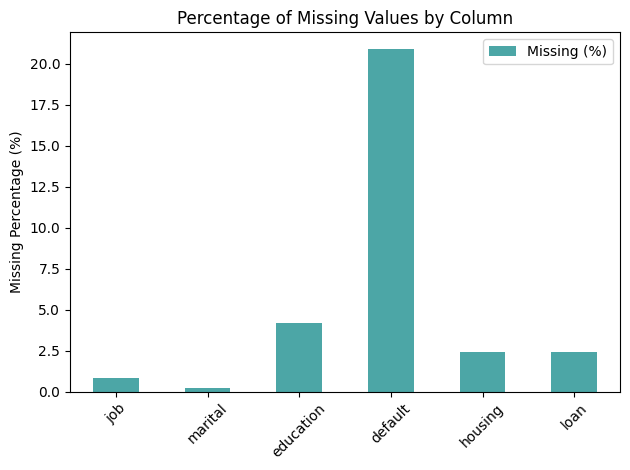

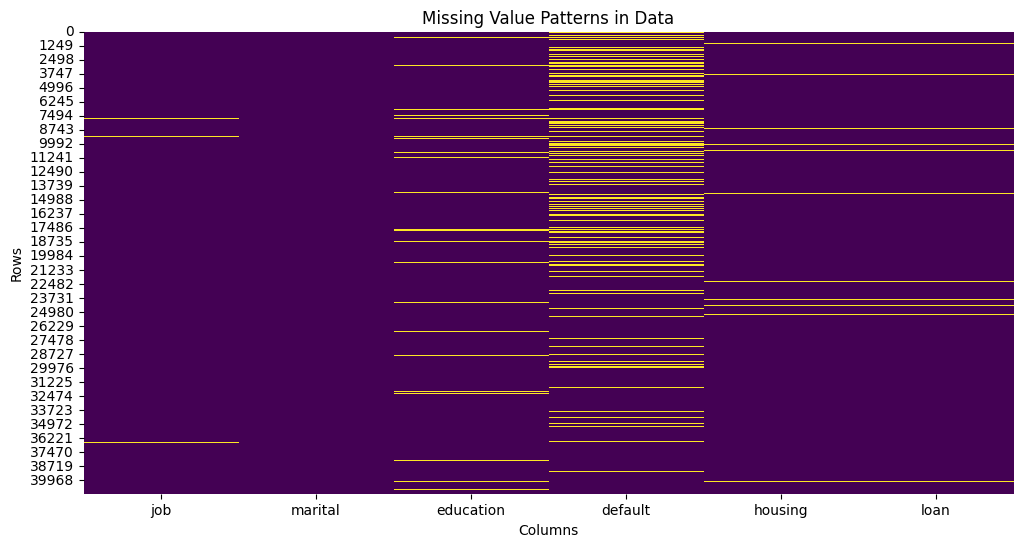

Missing Value Insights:
- job: 0.80%
- marital: 0.19%
- education: 4.20%
- default: 20.87%
- housing: 2.40%
- loan: 2.40%


In [10]:
# Treating 'unknown' as missing
df = df.replace('unknown', np.nan)

# Calculating missing value percentages
missing = df.isnull().mean() * 100
missing_df = pd.DataFrame({'Missing (%)': missing[missing > 0]})

# Bar plot for missing values
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    missing_df.plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Percentage of Missing Values by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Heatmap for missing value patterns
    plt.figure(figsize=(12, 6))
    sns.heatmap(df[missing_df.index].isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Value Patterns in Data')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Insights
print('Missing Value Insights:')
if missing_df.empty:
    print('- No missing values (including "unknown") detected.')
else:
    for col in missing_df.index:
        print(f'- {col}: {missing_df.loc[col, "Missing (%)"]:.2f}%')

Based on the previous chart, we can conclude that the attribute 'default' has over 20% of missing values, which can indicate a potential candidate to be discarded or filter out for further analysis.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The Business Objective is to classify the client will subscribe (yes/no) a term deposit (variable y).

In [11]:
# We will apply proper data cleaning to the previous dataframe to avoid getting unexpected results when the models predict the final results.
# For numerical features, median imputation will be applied, whereas , mode for categorical features will have the mode as the missingness flags.

# Identifying columns
numerical_cols = ['age','duration', 'campaign', 'pdays', 'previous',
                  'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome', 'y']

# Adding missingness flags
for col in df.columns:
    if df[col].isnull().any():
        df[f'is_missing_{col}'] = df[col].isnull().astype(int)

# Imputing missing values
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

# Verifying no missing values
print('Post-Cleaning Missing Values:', df.isnull().sum().sum())

Post-Cleaning Missing Values: 0


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

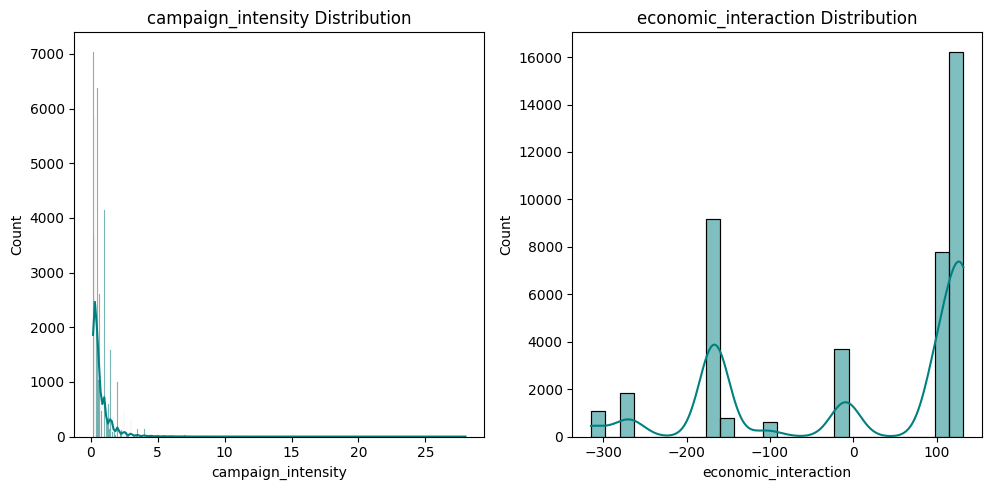

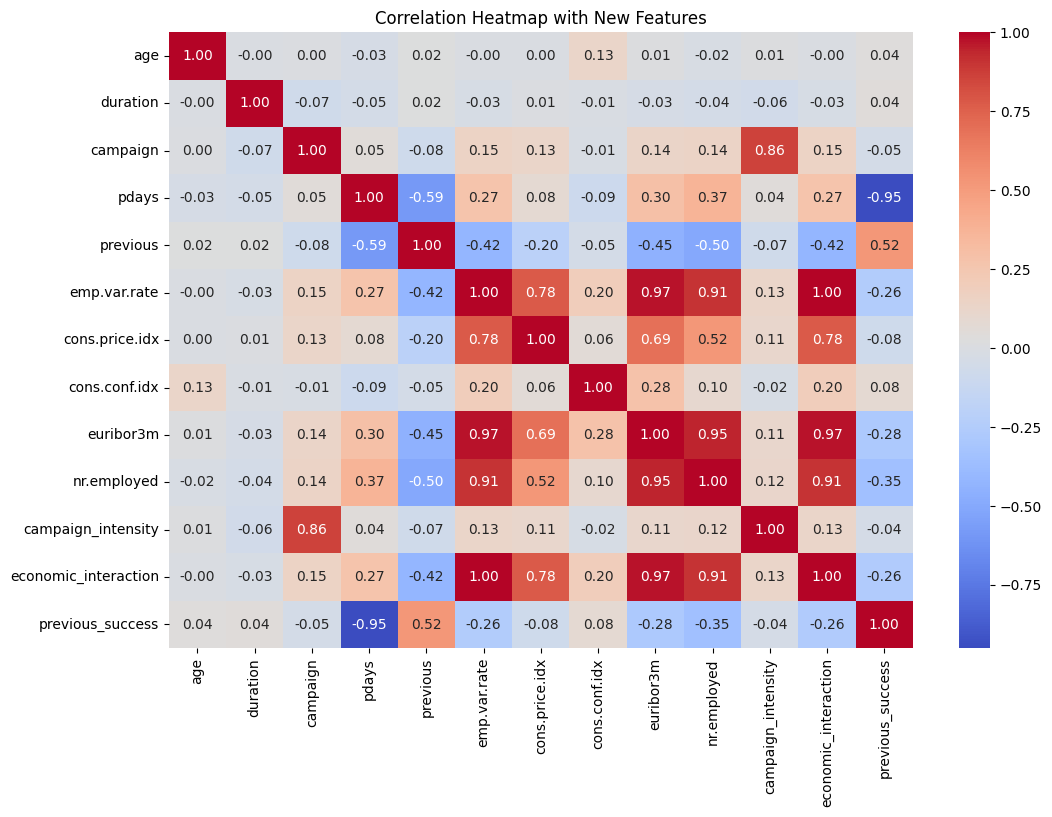

In [12]:
# We will create new features to capture client behavior and campaign effectiveness.

# Campaign Intensity - Trying to detect the weight of each day per campaign.
df['campaign_intensity'] = df['campaign'] / (df['day_of_week'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}) + 1)

# Previous Contact Success - if the previous contact made any effect in the upcoming campaign
df['previous_success'] = df['poutcome'].map({'success': 1, 'failure': 0, 'other': 0, 'nonexistent': 0})

# Age Binning - how the age can be linked to the campaign by age categories
df['age_bin'] = pd.cut(df['age'], bins=[18, 30, 45, 60, 100], labels=['young', 'adult', 'middle_age', 'senior'])

# Economic Indicator Interaction
df['economic_interaction'] = df['emp.var.rate'] * df['cons.price.idx']

# Update numerical and categorical columns
new_numerical_cols = ['campaign_intensity', 'economic_interaction']
numerical_cols.extend(new_numerical_cols)
categorical_cols.append('age_bin')

# Visualize new features
plt.figure(figsize=(15, 5))
for i, col in enumerate(new_numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols + ['previous_success']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap with New Features')
plt.show()

From the previous Correlation Map, there are a few numerical features which can indicate high correlation between each other and therefore the target attribute.

- emp.var.rate <-> euribor3m are **highly correlated**
- emp.var.rate <-> nr.employed are **highly correlated**
- emp.var.rate <-> economic_interaction are **highly correlated**
- const.conf.idx <-> economic_interaction are **correlated**
- previous_success <-> pdays are **inversely correlated**


## Let's explore the data by plotting the different attribute Distributions

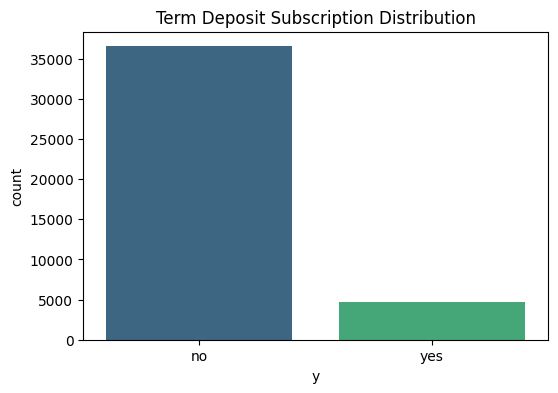

In [14]:
# EDA: Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df, palette='viridis')
plt.title('Term Deposit Subscription Distribution')
plt.show()



A basic analysis from the target column 'y' clearly indicates the imbalance in the values found. Most of the clients are not subscribing to the Term Deposit Subcriptions with up to 35k and only around 5k clients doing the needful.

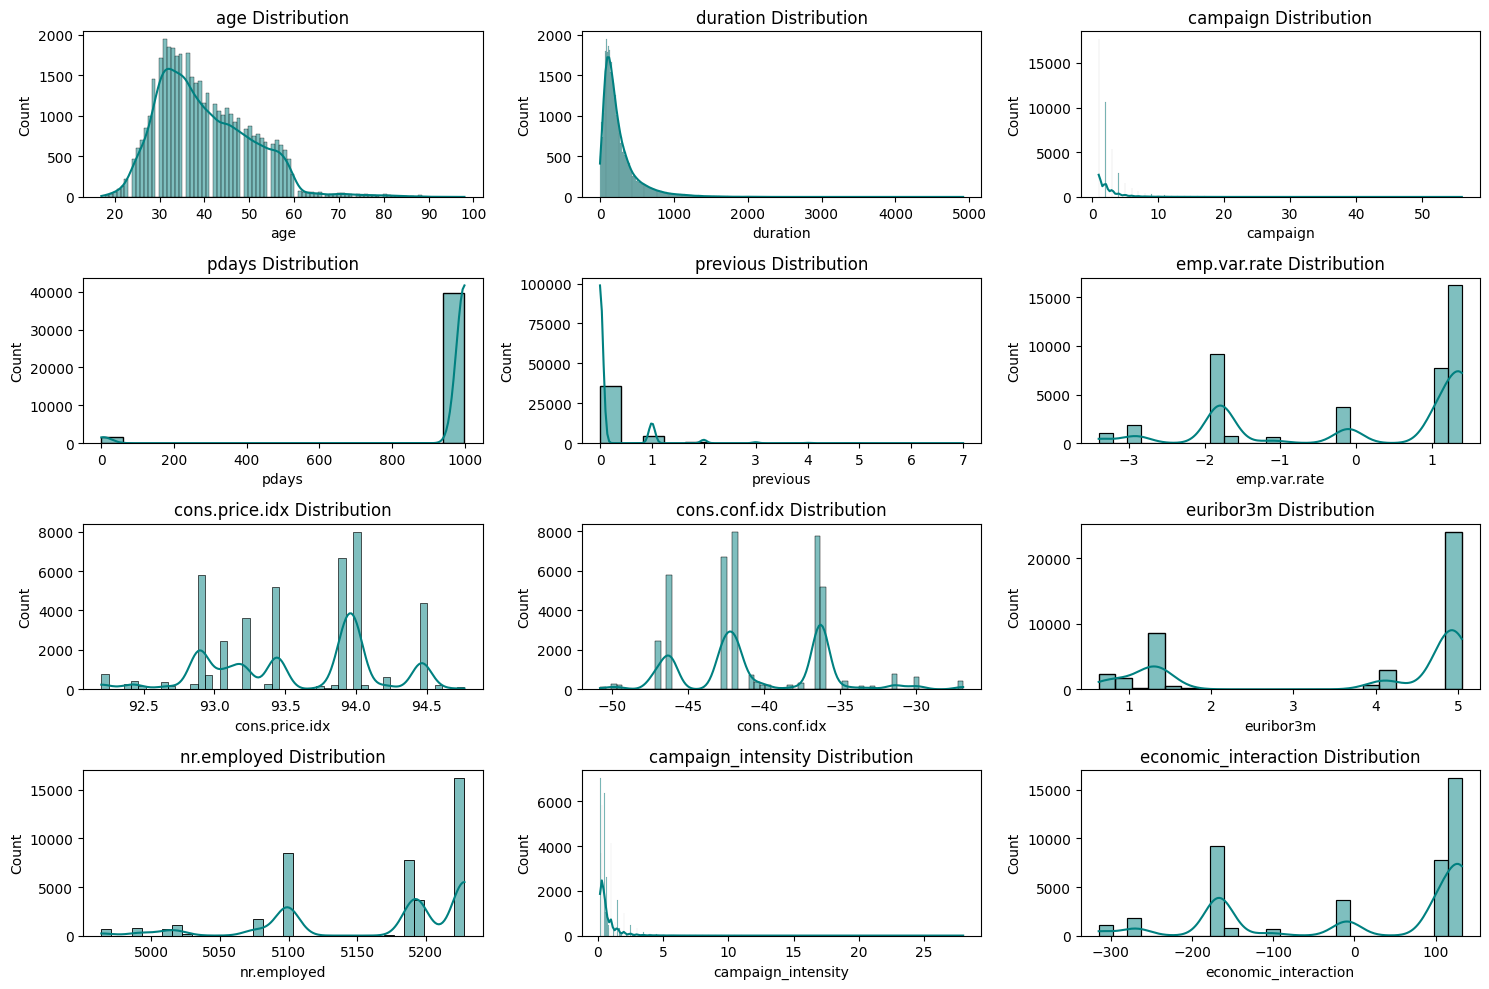

In [15]:
# Regarding the numerical features, let's explore their distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()



From the previous charts we can conclude that:
- Clients are aged mostly until 60 years old
- The duration of the subscriptions mostly last up to 1200 days
- Economic attributes do not follow regular patterns of analysis.

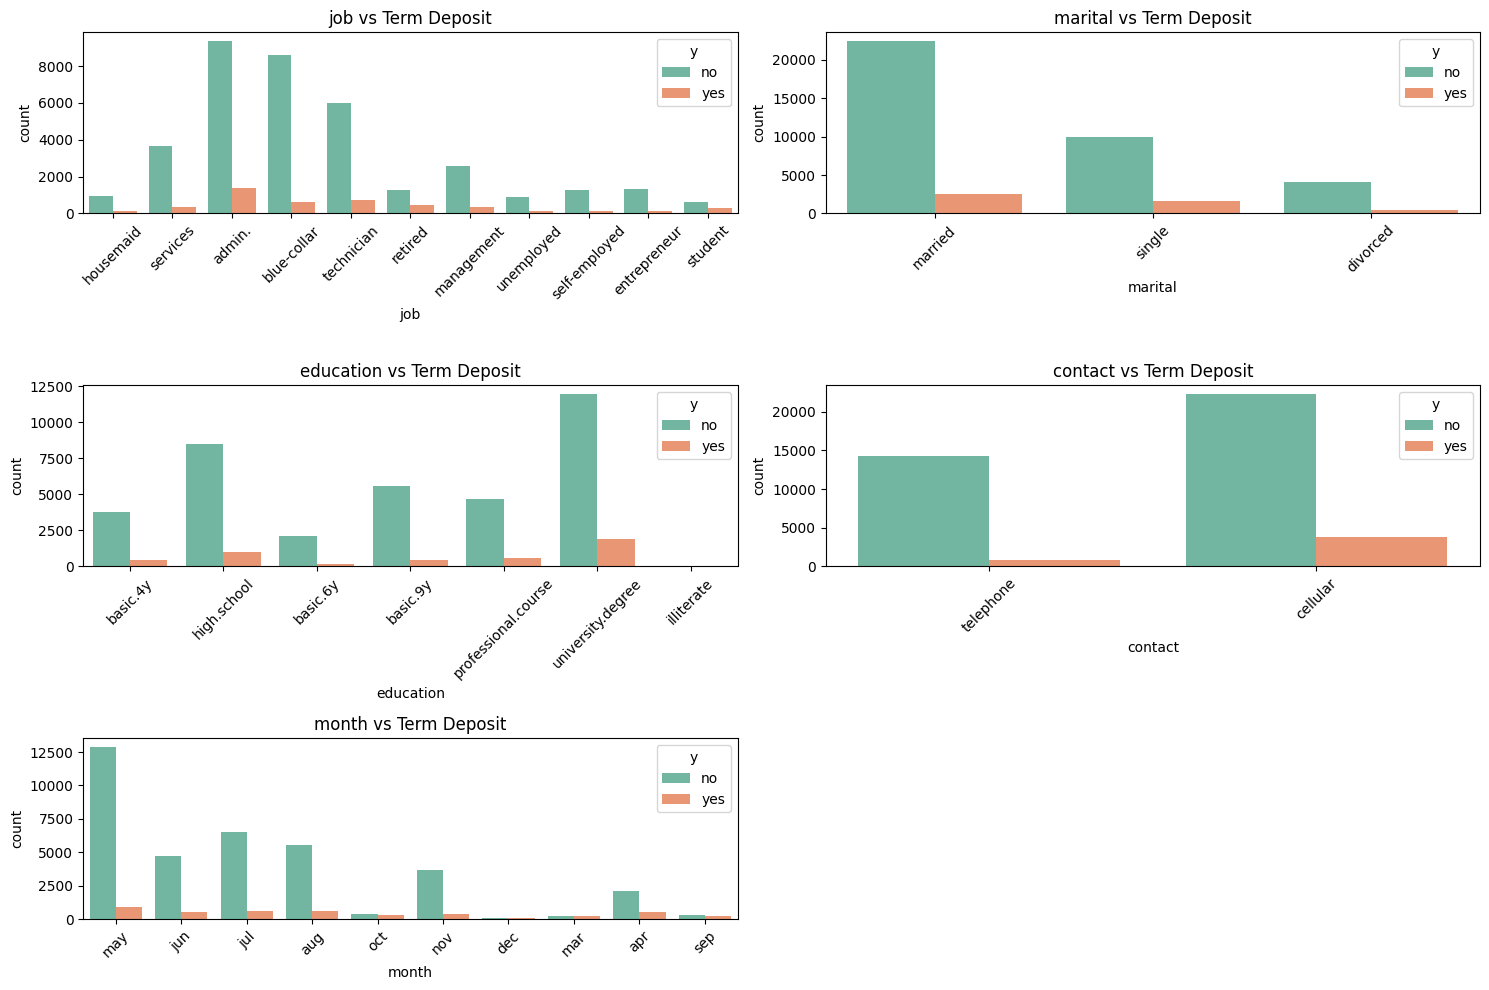

In [16]:
# For the categorical features vs. target, we can plot them as:
plt.figure(figsize=(15, 10))
for i, col in enumerate(['job', 'marital', 'education', 'contact', 'month'], 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, hue='y', data=df, palette='Set2')
    plt.title(f'{col} vs Term Deposit')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Main takeaways from the categorical features are:
- Job determines a lot wether the subscription will be successfull or not, with Admins, blue-collar and technician taking up the ranking.
- By marital status, the married and single clients are more prominent to answer the campaign and therefore to subscribe.
- By education level, we can detect that students ranging from high-school to university tend to top up most of the campaign requests.
- By type of contact, there is more preferable way of reaching the clients by cellular with up to 25k requests (including yes and no)
- The months which can be taken as more confident for campaigns are the ones in spring and summer.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [17]:
# Encoding categorical variables - to create a unique vector of values for each category.
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [18]:
# Defining features and target
X = df.drop(['y'], axis=1)
y = df['y']

In [19]:
# Splitting data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Scaling numerical features - due to large variation in the range of different numerical features, we will apply the standardscaler to normalize the values
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Training set class distribution:', pd.Series(y_train).value_counts().to_dict())

Training set shape: (32950, 30)
Test set shape: (8238, 30)
Training set class distribution: {0: 29238, 1: 3712}


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline performance to beat is the majority class of 'no'.

In [21]:
# We will create dummy classifier for the most frequent category of the target variable and obtain its accuracy as:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
baseline_accuracy = dummy.score(X_test, y_test)
print(f'Baseline Accuracy (Majority Class): {baseline_accuracy:.3f}')

Baseline Accuracy (Majority Class): 0.887


In [23]:
# Class distribution - to observe how the target variable is distributed between clients who subscribed (0) or not (1)
class_dist = pd.Series(y_train).value_counts(normalize=True)
print('Class Distribution in Training Set:')
print(class_dist)

Class Distribution in Training Set:
y
0    0.887344
1    0.112656
Name: proportion, dtype: float64


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [24]:
# Using the Logistic Regression  - we will set the property class_weight as 'balanced' due to the imbalanced found in the distribution of values for subscribed (0.11) and not subscribed (0.887)
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

### Problem 9: Score the Model

What is the accuracy of your model?

In [25]:
# Scoring Logistic Regression model
lr_train_acc = accuracy_score(y_train, lr_model.predict(X_train))
lr_test_acc = accuracy_score(y_test, lr_model.predict(X_test))
print(f'Logistic Regression Train Accuracy: {lr_train_acc:.3f}')
print(f'Logistic Regression Test Accuracy: {lr_test_acc:.3f}')

Logistic Regression Train Accuracy: 0.855
Logistic Regression Test Accuracy: 0.858


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [26]:
# Let's create a function to evaluate the different models and detect the training time, training accuracy and testing accuracy as:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    return {'Model': model_name, 'Train Time': train_time,
            'Train Accuracy': train_acc, 'Test Accuracy': test_acc}

In [27]:
# We will use the following models with the properties shown as:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced')),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('SVM', SVC(probability=True, random_state=42, class_weight='balanced'))
]

In [28]:
# Finally, we will evaluate each model by looping over the previous list 'models' and calling the previous function 'evaluate_model' as:
results = []
for name, model in models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(result)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [29]:
# First, we will do some more feature engineering exploration by getting a list of features ordered by importance (according to their Logistic Regression coefficients) to the target variable as:
lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': np.abs(lr.coef_[0])})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# The results are shown below as:
styled_fi = feature_importance.style.set_caption('Feature Importance (Logistic Regression)')\
    .format({'Coefficient': '{:.4f}'})\
    .background_gradient(cmap='Oranges', subset=['Coefficient'])\
    .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'border': '1px solid black'})\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
display(styled_fi)

,Feature,Coefficient
18,euribor3m,2.5852
19,nr.employed,1.7846
10,duration,1.7404
29,economic_interaction,1.1007
15,emp.var.rate,1.0815
7,contact,0.5304
23,is_missing_default,0.4604
14,poutcome,0.4595
20,is_missing_job,0.3312
12,pdays,0.2156


Looks like the Euribor value might influence quite a lot wether clients will opt for answering the subscriptions requests or not.

In [30]:
# For each of the models we will again, loop over the list of models, but also over a list of hyperparameters object of properties, where each model will be tested for a set of hyperparameters using Grid Search CV.
# We will create another function to achieve so, and return the Training time, the training accuracy, the test accuracy, the test F1 Score and the Test AUC.

def evaluate_tuned_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Best model metrics
    best_model = grid.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    y_prob_test = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, zero_division=0)
    test_auc = roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else None

    return {
        'Model': model_name,
        'Best Params': grid.best_params_,
        'Train Time': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Test F1 Score': test_f1,
        'Test AUC': test_auc
    }

In [31]:
# The different hyperparameter values are considered in the following object
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'Decision Tree': {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

In [32]:
# Now it is time to evaluate each of the models by calling the function 'evaluate_model_tuned' along with the different hyperparameters object as:
tuned_results = []
for name, model in models:
    result = evaluate_tuned_model(model, param_grids[name], X_train, y_train, X_test, y_test, name)
    tuned_results.append(result)

tuned_results_df = pd.DataFrame(tuned_results)
styled_tuned = tuned_results_df.style.set_caption('Tuned Model Performance')\
    .format({'Train Time': '{:.2f}', 'Train Accuracy': '{:.3f}', 'Test Accuracy': '{:.3f}',
             'Test F1 Score': '{:.3f}', 'Test AUC': '{:.3f}'})\
    .background_gradient(cmap='Blues', subset=['Train Accuracy', 'Test Accuracy', 'Test F1 Score', 'Test AUC'])\
    .highlight_min(subset=['Train Time'], color='lightgreen')\
    .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'border': '1px solid black'})\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
display(styled_tuned)

,Model,Best Params,Train Time,Train Accuracy,Test Accuracy,Test F1 Score,Test AUC
0,Logistic Regression,{'C': 10},12.81,0.855,0.858,0.590,0.939
1,KNN,{'n_neighbors': 3},26.86,0.941,0.898,0.475,0.822
2,Decision Tree,"{'max_depth': 7, 'min_samples_split': 2}",4.99,0.851,0.845,0.572,0.936
3,SVM,"{'C': 10, 'gamma': 'scale'}",5698.61,0.860,0.854,0.589,0.943


### Insights
#### Best Overall Performance (Balanced Metrics):

- **Logistic Regression and Decision Tree/SVM** have **similar test accuracy and F1 scores**.
- **SVM and Decision Tree have the highest AUC**, indicating strong classification performance.

#### Efficiency:

**Decision Tree is the fastest to train**, making it ideal for quick iterations.
**SVM has the longest training time**, which may be impractical for large datasets or frequent retraining.

#### Overfitting Risk:

KNN shows high train accuracy but lower F1 score and AUC, suggesting potential overfitting or poor generalization.

#### Trade-offs:

**Logistic Regression offers a good balance between performance and training time**.
**Decision Tree** is nearly as accurate as Logistic Regression but **faster**.
**SVM** matches Decision Tree in performance but is **computationally expensive**.

### Recommendation
For practical use, where training time matters, **Decision Tree or Logistic Regression are strong choices**.

##### Questions